[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/guiwitz/MLCV/blob/main/notebooks/03-Simple_NN.ipynb)
# 3. Neural networks with PyTorch

Neural networks can be programmed on different levels depending on how much one needs to customize either the architecture or the training pattern. When dealing with more complex NN we will use a higher-level package (Lightning, see [Chapter 8](08-Lightning.ipynb)) which will spare us some "manual" work. However, in order to understand all steps involved in designing a DL algorithm, we will first use basic PyTroch. In this notebook we will see howe we can *design* a NN while in [the next notebook](05-Training.ipynb) we will se how to train it.

In [19]:
# set path containing data folder or use default for Colab (/gdrive/My Drive)
local_folder = "../"
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/guiwitz/DLImaging/master/utils/check_colab.py', 'check_colab.py')
from check_colab import set_datapath
colab, datapath = set_datapath(local_folder)

## Layer from torch.nn

We will see in this notebook how to create a simple neural network for image classification using the most general mechanism in PyTorch which are modules. All module-related objects and functions are contained in ```torch.nn```. As the name indicates, these modules are really *modular* in the sense that they are indpendent parts of networks that can be combined together. Mostly we will use single modules containing the multiple layers of our architecture, but we will also see examples where multiple modules are assembled.

A module is essentially an assemble of multiple other modules, and many of these are provided "pre-made" for us also available in ```torch.nn```. For example in the simple network used here we will only use linear layers. Before we create an actual network let's see how layers work:

In [21]:
import torch
torch.manual_seed(42);
from torch import nn

We creat now a linear layer that takes a vector of size 5 as input and ouptuts a vector of size 10:

In [21]:
lin_layer = nn.Linear(in_features=5, out_features=10)

This single layer already has parameters:

In [22]:
list(lin_layer.parameters())

[Parameter containing:
 tensor([[ 0.3419,  0.3712, -0.1048,  0.4108, -0.0980],
         [ 0.0902, -0.2177,  0.2626,  0.3942, -0.3281],
         [ 0.3887,  0.0837,  0.3304,  0.0606,  0.2156],
         [-0.0631,  0.3448,  0.0661, -0.2088,  0.1140],
         [-0.2060, -0.0524, -0.1816,  0.2967, -0.3530],
         [-0.2062, -0.1263, -0.2689,  0.0422, -0.4417],
         [ 0.4039, -0.3799,  0.3453,  0.0744, -0.1452],
         [ 0.2764,  0.0697,  0.3613,  0.0489, -0.1410],
         [ 0.1202, -0.1213,  0.1882,  0.3993,  0.2585],
         [-0.1955,  0.2582,  0.0800,  0.2271, -0.2726]], requires_grad=True),
 Parameter containing:
 tensor([-0.4427, -0.1728, -0.3430,  0.3670,  0.1288,  0.1852,  0.1414, -0.0078,
          0.3500, -0.3178], requires_grad=True)]

We see that we have indeed a 5x10 matrix plus the bias term of size 10. When we later assemble multiple modules, we will see the same time of output but with many more parameters.

## Passing an input

Our layer takes a vector as an input so let's create a tensor of size 5:

In [23]:
import torch

In [34]:
mytensor = torch.randint(0,100,(5,))
mytensor

tensor([61, 23, 20, 11, 61])

No we we pass it to ```lin_layer```:

In [35]:
lin_layer(mytensor)

RuntimeError: expected scalar type Long but found Float

In [36]:
mytensor.dtype

torch.int64

In [37]:
lin_layer.weight.dtype

torch.float32

The error can be a bit misleading. The problem here is that the weights in the layer are defined by default as ```float32```. Hence the input should match this but we passed an 64 bits integer which creates a conflict. Let's adjust the type of our tensor. We can either modify the tensor:

In [38]:
mytensor_float = mytensor.float()

Now we finally have the right object to path through our network:

In [39]:
output = lin_layer(mytensor_float)
output

tensor([ 25.3977, -10.0996,  45.7222,  10.4237, -35.5498, -47.1532,  14.9067,
         17.6140,  28.8162, -18.8349], grad_fn=<AddBackward0>)

In [40]:
output.shape

torch.Size([10])

We see that the ouput has as expected as size of 10! Of course we can now add as many other layers as we want:

In [41]:
lin_layer2 = nn.Linear(10,3)
output = lin_layer2(output)

In [42]:
output.size()

torch.Size([3])

## Activation

In addition to *layers* we will typically also need activation functions such as soft-max. Those are implemented as layer objects in ```torch.nn``` as well as functions in ```torch.functional```:

In [27]:
import torch.nn.functional as F

Since we use the functional form, we can pass the output of the above linear layer directly to the activation function, here a ReLU:

In [49]:
lin_layer_activated = F.relu(output)

In [50]:
lin_layer_activated

tensor([37.3864,  0.0000, 34.4119], grad_fn=<ReluBackward0>)

or we create a dedicated layer:

In [51]:
relu_layer = nn.ReLU()

In [52]:
relu_layer(output)

tensor([37.3864,  0.0000, 34.4119], grad_fn=<ReluBackward0>)

## Structure of a network

There are two ways to assemble layers and activation functions into a NN architecture. In the first one, we just specify a sequence of layers and activations:

In [53]:
model = nn.Sequential(
    nn.Linear(5,10),
    nn.ReLU(),
    nn.Linear(10,3)
)

This is very easy to implement for simple networks but limited to use more complex architectures such as Unets where one has to "manually" intervene e.g. to create links between layers. In that case we can implement the model as a calls of type ```nn.Module``` in which we can define layers, and combine them how we want in a ```forward``` function:

In [54]:
class Mynetwork(nn.Module):
    def __init__(self, myparameter1, myparameter2):
        super(Mynetwork, self).__init__()
        
        # define e.g. layers here e.g.
        self.layer1 = nn.Linear(myparameter1, 5)
        self.layer2 = nn.Linear(5, myparameter2)

    def forward(self, x):
        
        # define the sequence of operations in the network including e.g. activations
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        
        return x

Above, we have defined a simple network that is defined by two parameters, ```myparameter1, myparameter2```, and which is composed of two linear layers and ReLU unit. The differnt layers that we need are defined in ```__init__``` as object parameters and then re-used in the network definition in the ```forward``` function. ```forward``` takes an input ```x``` (e.g. an image to classify), passes it through the network and outputs the result. Therefore in principle we could instantiate a model and use it like this:

```
mymodel = Mynetwork(9,3)
mymodel.forward(myinput)
```

However, ```nn.Module``` has a ```__call__``` attribute that allows us to use the class as a function like this:

```
mymodel = Mynetwork(9,3)
mymodel(myinput)
```

This is actually **how a module should be properly used** in order to exploit all capabilities offered in PyTorch.

Let's now try this out. We instantiate the model:

In [55]:
mymodel = Mynetwork(9,3)

Just like for the single linear layer before, we can have a look at all parameters:

In [56]:
list(mymodel.parameters())

[Parameter containing:
 tensor([[ 0.1865, -0.2321,  0.1675,  0.1513,  0.2381, -0.2557,  0.2397, -0.1576,
           0.1237],
         [ 0.3130, -0.0470, -0.0026, -0.0767, -0.2783,  0.1600, -0.3309,  0.2069,
           0.2494],
         [ 0.3152, -0.0786, -0.2739,  0.0749,  0.1841, -0.3318, -0.0757, -0.1998,
          -0.0292],
         [-0.1641, -0.1363, -0.1058, -0.3168,  0.2735,  0.2794, -0.0523, -0.0380,
          -0.1360],
         [-0.3010, -0.3244,  0.1239, -0.1830, -0.2143, -0.0260, -0.1110, -0.1078,
           0.0107]], requires_grad=True),
 Parameter containing:
 tensor([-0.0707, -0.1148, -0.1596, -0.2713,  0.2795], requires_grad=True),
 Parameter containing:
 tensor([[-0.1790,  0.1185, -0.1552,  0.0363,  0.4169],
         [ 0.2060, -0.3876,  0.1775,  0.4245,  0.1177],
         [ 0.2998,  0.4409, -0.0685,  0.0928, -0.3108]], requires_grad=True),
 Parameter containing:
 tensor([-0.0922,  0.3312,  0.2293], requires_grad=True)]

The output is the same, only now we see all parameters from all layers, not just a single one. We can also look at the modules contained in our network:

In [57]:
list(mymodel.modules())

[Mynetwork(
   (layer1): Linear(in_features=9, out_features=5, bias=True)
   (layer2): Linear(in_features=5, out_features=3, bias=True)
 ),
 Linear(in_features=9, out_features=5, bias=True),
 Linear(in_features=5, out_features=3, bias=True)]

We see some repeats because we see here modules at all levels. E.g. each linear layer is a module but our entire network is a module as well.

We can also just find all modules contained in our main module and recover its name and function:

In [58]:
for name, module in mymodel.named_children():
    print(f'name: {name} module: {module}')

name: layer1 module: Linear(in_features=9, out_features=5, bias=True)
name: layer2 module: Linear(in_features=5, out_features=3, bias=True)


We can also obtain a dictionary of all layers with their weights:

In [59]:
mymodel.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.1865, -0.2321,  0.1675,  0.1513,  0.2381, -0.2557,  0.2397, -0.1576,
                        0.1237],
                      [ 0.3130, -0.0470, -0.0026, -0.0767, -0.2783,  0.1600, -0.3309,  0.2069,
                        0.2494],
                      [ 0.3152, -0.0786, -0.2739,  0.0749,  0.1841, -0.3318, -0.0757, -0.1998,
                       -0.0292],
                      [-0.1641, -0.1363, -0.1058, -0.3168,  0.2735,  0.2794, -0.0523, -0.0380,
                       -0.1360],
                      [-0.3010, -0.3244,  0.1239, -0.1830, -0.2143, -0.0260, -0.1110, -0.1078,
                        0.0107]])),
             ('layer1.bias',
              tensor([-0.0707, -0.1148, -0.1596, -0.2713,  0.2795])),
             ('layer2.weight',
              tensor([[-0.1790,  0.1185, -0.1552,  0.0363,  0.4169],
                      [ 0.2060, -0.3876,  0.1775,  0.4245,  0.1177],
                      [ 0.2998,  0.4409, -0.0685,  0.0928,

Finally we can pass an input through our network. It takes an input of size 9:

In [60]:
my_input = torch.randn((9,))

In [61]:
output = mymodel(my_input)

In [62]:
output

tensor([-0.0596,  0.7805,  0.3574], grad_fn=<AddBackward0>)

## Batches

If we want to use batch processing, we can also pass batches of vectors through the network instead of single vectors. PyTroch layers are designed to handle this by default, so here for example if we want to use a batch of size 32 we can just use a 32 x 8 tensor. We create one directly with ```torch.randn``` here (we will learn more about batches in the chapter on training):

In [63]:
batch_tensor = torch.randn(32,9)
batch_tensor.shape

torch.Size([32, 9])

In [64]:
batch_output = mymodel(batch_tensor)

In [65]:
batch_output.shape

torch.Size([32, 3])

We see that the output is "batched" as well, so the network gracefully handlend this batch for us.

## Passing an image as input

One complexity when dealing with images, is making sure that the input/output dimensions (and we'll see later, dimensions inside the network) are appropriate. For example at the moment our network has a linear layer as input, so we would need to make sure our image is "linear".

Let's consider an image from the MNIST dataset (images of handwritten numbers):

In [2]:
import imageio.v3 as iio
import matplotlib.pyplot as plt

In [78]:
image = iio.imread('https://datasets-server.huggingface.co/assets/mnist/--/mnist/train/0/image/image.jpg')
image = torch.from_numpy(image)
image = image.float()

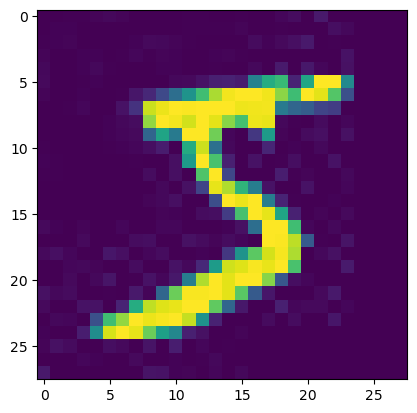

In [79]:
plt.imshow(image);

If we want to pass this image as input to a linear layer, we need to somehow concatenate all rows together. Obviously by doing that we loose interesting features in the image, and we'll see later how we can keep those using convolution later (note that this linearization is always present in the last layer of a classifier).

To linearize this image, we can use the ```flatten``` function:

In [81]:
image_flat = image.flatten()
image_flat.shape

torch.Size([784])

Alternatively we can use the ```view``` method and instead of specifying axes, just use -1:

In [83]:
image_flat = image.view(-1)
image_flat.shape

torch.Size([784])

To pass these $28*28 = 784$ values to our network we of course need to adjust the input size:

In [85]:
mymodel = Mynetwork(784,20)

In [86]:
output = mymodel(image_flat)

In [87]:
output

tensor([-23.5123,  22.6542, -28.8260,  20.3478, -13.7348,  29.9258,   4.7831,
        -30.3402,  27.6189, -17.3178, -27.2706, -15.8357, -44.8007,  26.7763,
          6.5294, -10.0950,  39.2811,  17.6796,  37.0028, -12.5746],
       grad_fn=<AddBackward0>)

The operation of "flattening" can be done at different places. For example, instead of flattening the input, we can also flatten within our network definition:

In [88]:
class Mynetwork2(nn.Module):
    def __init__(self, myparameter1, myparameter2):
        super(Mynetwork2, self).__init__()
        
        # define e.g. layers here e.g.
        self.layer1 = nn.Linear(myparameter1, myparameter2)

    def forward(self, x):
        
        x = x.view(-1)
        # define the sequence of operations in the network including e.g. activations
        x = F.relu(self.layer1(x))
        
        return x

In [89]:
second_model = Mynetwork2(784, 20)

In [91]:
output = second_model(image)
output

tensor([ 32.3195,  22.5286,  64.9188,   0.0000,   0.0000,  72.3183,  19.4446,
          0.0000,   4.9189,   0.0000,  11.2640, 101.6435,  22.4040,   0.0000,
         45.0949,  25.2079,   0.0000,   0.0000,   3.9653,   0.0000],
       grad_fn=<ReluBackward0>)

In [92]:
output.shape

torch.Size([20])

### Image batches

We have to be a bit careful when operating with image batches. Let's start with manually importing two images:

In [6]:
image1 = iio.imread('https://datasets-server.huggingface.co/assets/mnist/--/mnist/train/0/image/image.jpg')
image2 = iio.imread('https://datasets-server.huggingface.co/assets/mnist/--/mnist/train/1/image/image.jpg')
image1 = torch.from_numpy(image1)
image1 = image1.float()
image2 = torch.from_numpy(image2)
image2 = image2.float()

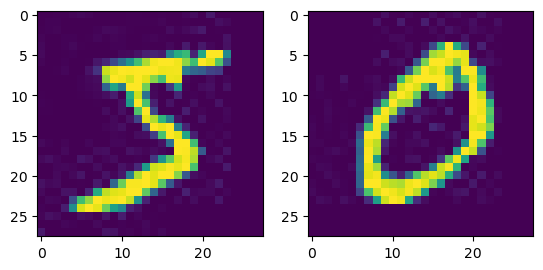

In [8]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image1)
ax[1].imshow(image2);

Now we can assemble these two images into a stack:

In [10]:
image_batch = torch.stack([image1, image2], axis=0)

In [11]:
image_batch.shape

torch.Size([2, 28, 28])

We see from the dimensions that we indeed have now a batch of two images. The problem is that this will be interpreted by PyTorch as an image with multiple channels (like an RGB image) and not as a batch because the expected dimensions are ```Batch-Channel-PixelsX-PixelsY```. So we have to add an "empty" dimension between the batch dimension and the pixel dimensions using the ```unsqueeze``` function:

In [12]:
image_batch = torch.unsqueeze(image_batch, dim=1)

In [13]:
image_batch.shape

torch.Size([2, 1, 28, 28])

Also now that we have a batch, the "unwrapping" of the image in a linear shape cannot be done simply using ```view(-1)``` or ```flatten```:

In [16]:
image_batch.flatten().shape

torch.Size([1568])

As you can see above this concatenates all images in the batch into one large image. We have to specify that we want to leave the batch dimension *untouched*:

In [18]:
image_batch.flatten(start_dim=1).shape

torch.Size([2, 784])

Now we have a batch of two linearized images! If we update our model, we have now:

In [28]:
class Mynetwork3(nn.Module):
    def __init__(self, myparameter1, myparameter2):
        super(Mynetwork3, self).__init__()
        
        # define e.g. layers here e.g.
        self.layer1 = nn.Linear(myparameter1, myparameter2)

    def forward(self, x):
        
        x = x.flatten(start_dim=1)
        # define the sequence of operations in the network including e.g. activations
        x = F.relu(self.layer1(x))
        
        return x

Now we can instantiate the model and pass our "fake" batch through it: 

In [30]:
model_batch = Mynetwork3(784, 3)
out = model_batch(image_batch)
    

In [31]:
out.shape

torch.Size([2, 3])

Our output is indeed composed of a batch of 2, each element having 3 outputs.

## Saving and loading a model

Our next goal will be to train our network (see next chapter). At some point during or after training we will want to save both our model and its weights. This can be done in two ways.

### Save full model

First, we can save the entire model so that it can be simply reloaded. This is practical when developing but can lead to problems when moving saved models between computers. First we save our model (create a ````models```` folder in your directory if needed):

In [47]:
torch.save(second_model, datapath.joinpath('models/simpleNN.pt'))

And reload it:

In [48]:
third_model = torch.load(datapath.joinpath('models/simpleNN.pt'))

In [49]:
third_model(image)

tensor([2.9879, 2.2543, 0.6235, 0.0000, 0.0000, 2.0040, 9.6056, 8.4799, 0.0000,
        0.0000, 1.5722, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.2356,
        0.0000, 0.0000], grad_fn=<ReluBackward0>)

And we see that we obtain the same values as above, meaning that the parameters were indeed saved.

### Saving the model state

Alternatively we can simply save all the parameters, which is a safer method. We simply recover them using ```state_dict```:

In [50]:
torch.save(third_model.state_dict(),datapath.joinpath('models/simpleNN_state.pt'))

To reload the parameters we of course now have to first instantiate the model and "fill" it with those values using ```load_state_dict```:

In [51]:
fourth_model = Mynetwork2(784, 20)

In [52]:
params = torch.load(datapath.joinpath('models/simpleNN_state.pt'))
params

OrderedDict([('layer1.weight',
              tensor([[-0.0037,  0.0130,  0.0145,  ...,  0.0164, -0.0147,  0.0120],
                      [ 0.0044,  0.0146, -0.0086,  ..., -0.0005,  0.0144, -0.0196],
                      [ 0.0279, -0.0238, -0.0311,  ..., -0.0305,  0.0024,  0.0009],
                      ...,
                      [ 0.0090, -0.0278, -0.0105,  ...,  0.0123,  0.0218,  0.0213],
                      [ 0.0242,  0.0156,  0.0108,  ...,  0.0154, -0.0153,  0.0217],
                      [-0.0239,  0.0014,  0.0069,  ..., -0.0070, -0.0050, -0.0247]])),
             ('layer1.bias',
              tensor([-0.0300,  0.0135,  0.0126, -0.0301,  0.0079, -0.0219,  0.0166, -0.0311,
                      -0.0126,  0.0305, -0.0181, -0.0226,  0.0038, -0.0043, -0.0073,  0.0127,
                       0.0165,  0.0203, -0.0097,  0.0190]))])

In [53]:
fourth_model.load_state_dict(params)

<All keys matched successfully>

In [54]:
fourth_model(image)

tensor([2.9879, 2.2543, 0.6235, 0.0000, 0.0000, 2.0040, 9.6056, 8.4799, 0.0000,
        0.0000, 1.5722, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.2356,
        0.0000, 0.0000], grad_fn=<ReluBackward0>)

## Running on a GPU (run on Colab)

If you want to exploit the computational power of a GPU you have to take care of moving **both** the model and the data to it. First, find out if you have a GPU. You can test this for example by running this notebook on Colab:

In [58]:
torch.cuda.is_available()

True

If you have a GPU, you can define it as a device. If not you can fall back on CPU:

In [59]:
if torch.cuda.is_available():
    dev = torch.device("cuda")
else:
    dev = torch.device("cpu")

Now finally if you want to use it with a model you need to move the model to it. Let's check where it currently sits:

In [60]:
second_model.to(dev)

Mynetwork2(
  (layer1): Linear(in_features=1024, out_features=20, bias=True)
)

In [61]:
list(second_model.parameters())

[Parameter containing:
 tensor([[-6.5818e-03, -1.3050e-05, -2.1981e-02,  ...,  2.0436e-02,
          -1.8892e-03, -2.1725e-02],
         [ 2.0734e-02, -1.9473e-02, -2.8260e-02,  ...,  2.5199e-02,
          -2.9951e-02,  8.9792e-03],
         [-1.3109e-03,  1.3450e-02,  1.9928e-02,  ..., -5.7713e-03,
           1.0590e-02, -1.9134e-02],
         ...,
         [ 1.6805e-02,  2.3167e-02,  3.1948e-03,  ..., -1.5454e-02,
           1.3553e-02, -1.7430e-02],
         [-2.3587e-02, -1.8857e-02,  9.4816e-03,  ...,  2.1235e-02,
          -2.0854e-02, -2.8723e-02],
         [ 2.1510e-03, -4.4486e-03, -1.7398e-02,  ..., -1.2099e-02,
           1.0446e-02,  2.7855e-03]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0084,  0.0012,  0.0020,  0.0185,  0.0250, -0.0038,  0.0236, -0.0299,
          0.0036,  0.0277, -0.0210, -0.0126, -0.0142, -0.0256, -0.0099,  0.0236,
          0.0120, -0.0239,  0.0216, -0.0094], device='cuda:0',
        requires_grad=True)]

Now if we try to pass our current image through the network we get an error:

In [62]:
second_model(image)

RuntimeError: ignored

The error message is quite explicit: you then need also to move the data, both for training and inference to the GPU:

In [63]:
image.to(dev)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [64]:
image = image.to(dev)

In [65]:
output = second_model(image)

In [66]:
output

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  4.2747, 12.7591,  0.0000,  0.0000,
         3.2894,  3.1473,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        14.3413,  7.2331,  0.0000,  0.0000], device='cuda:0',
       grad_fn=<ReluBackward0>)

The output sits on the GPU and is part of the gradient calcualtion, so if you want to further use it, you will have to pull it from the GPU **and** detach it from gradient calculation:

In [67]:
output.detach().cpu().numpy()

array([ 0.       ,  0.       ,  0.       ,  0.       ,  4.2747416,
       12.759116 ,  0.       ,  0.       ,  3.2893572,  3.1472843,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       , 14.341337 ,  7.2330832,  0.       ,  0.       ],
      dtype=float32)

## Exercises

1. Create a network with 4 successive linear layers of size 20,40 and 100 and 2, and ReLU activation after the three first layers. It takes a 2D input.
2. With ```imageio``` import the image in ```.../data/woody_baille.JPG```
3. Instantiate your model with the appropriate size
4. Run the image through the network and turn the output into a numpy array
